# Victorian Education Data Analysis Project
**Name:** Akira Wang  
**Domain**: Education, State Government Funding, Housing Rental Cost  

**Datasets:**
1. 2016-2017 VCAA School Dataset (Obtained from the Head Data Analyst of VCAA)
2. 2016-2017 Housing rent cost in Victoria quarterly (https://www.data.vic.gov.au/data/dataset/rental-report-quarterly-moving-annual-rents-by-suburb)
3. 2016-2017 State budget for Education and Training (https://www.data.vic.gov.au/data/dataset/state-budget-2017-18-department-of-education-and-training-financial-statements)
4. 2016 On Track Year 12 or equivalent (https://www.data.vic.gov.au/data/dataset/2016-on-track-year-12-or-equivalent-completers-student-level-destination-data)
5. 2015-2016 Department of Education and Training Contractors (https://www.data.vic.gov.au/data/dataset/det-contractors-2015-16)

**Why these datasets:**
- The first dataset is the major one, with information about the school as well as its performance
- The second is to find the average housing prices of each suburb and see if there is any correlation
- The third and fifth dataset is to check the budget of the education system, and where most of the actual funding goes to
- The fourth dataset is to see where most students go after graduating by sector. We can make assumptions on where students will go based on their sector

**Question:**  
*What are the key factors that determines a high school's performance in VCE*

**Why this area?**  
*The Victorian education system has had numerous changes in the recent years, as well as the increasing number of demands for higher achieving schools with families. I thought it would be interesting to see if the location of a school as well as the students that attend it would have any impact on a schools overall performances. Especially in Melbourne, we are diverse in high schools with a large bulk of independent and catholic run schools.


**Sub Questions:**  
1. What are some of the attributes that a high achieving school has?
    - Selective entry?
    - Subjects offerend?
    - Number of students?
    - Location?
2. Does the location (housing cost) have any correlation with a school's performance / services offered?
    - Do expensive suburbs have higher performing schools?
    - Is there any valid correlation to support this?
    - Do certain suburbs offer a larger variety of school sectors?
    - Whats the difference between a low rent area vs high rent area?
3. Has the budget for education changed any performance of the schools?
    - Does the increase in budget = increase in performance?
    - How much was spent in schools specifically?
4. What ultimately happens to high school graduates?
    - Is it worth the extra money to implement more educational services?
    - Where do they mainly go?
    - Which destination is predominant?
5. What labels are accurate for high achieving schools / sectors?
    - NMI
    - Label that determines the biggest bulk of predicting
    - Results

# Imports

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from IPython.display import display

# Visualization libraries
import graphviz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('seaborn')

# Machine Learning models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from collections import defaultdict

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import clean csv's
df1 = pd.read_csv('clean_VCAA_data.csv').drop('Unnamed: 0', axis=1)
df2 = pd.read_csv('clean_VSGfunding_data.csv').set_index('Unnamed: 0')
df2.index.name = 'Year'
df3 = pd.read_csv('clean_VCAAandHousingPrice.csv').drop('Unnamed: 0', axis=1)
df4 = pd.read_csv('clean_ontrack_2016.csv').drop('Unnamed: 0', axis=1)
df5 = pd.read_csv('clean_contractors_2016-2017.csv').drop('Unnamed: 0', axis=1)

In [3]:
# Function from phase 2
def my_entropy(probs):
    return -probs.dot(np.log2(probs))
def mutual_info(X,Y):
    
    df = pd.DataFrame.from_dict({'X' : X,  'Y' :Y})
    Hx = my_entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = my_entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(["X","Y"]).size()
    probs = counts/ counts.values.sum()
    H_xy = my_entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy)  
    return NMI

# What do the clean dataset look like?

In [4]:
# Complete dataset for VCAA split into 2016 and 2017
df1.head(3)

,Year,Sector,School,Locality,Number of Unit 3/4 VCE Stubjects Offered,Number of VET Subjects Offered,IB Offered,Number of VCE Enrollments,Number of VET Enrollments,Number of VCAL Enrollments,Percentage of VCE students applying for tertiary places,VCE Percentage of Sastisfactory Completion,Number of students awarded the VCE (Baccalaureate),VET Percentage of Sastisfactory Completion,VCAL Percentage of Sastisfactory Completion,Median VCE study score,Percentage of study scores of 40 and over
0,2017,CATHOLIC,ACADEMY OF MARY IMMACULATE,FITZROY,41,6,0,149,17,0,93,96,9,99.0,0.0,31.0,12.4
1,2017,INDEPENDENT,AITKEN COLLEGE,GREENVALE,52,23,0,165,135,22,94,100,6,91.0,100.0,29.0,6.1
2,2017,INDEPENDENT,AL SIRAAT COLLEGE,EPPING,12,2,0,34,48,0,100,100,0,99.0,0.0,25.0,2.2


In [5]:
# The 2016-2017 budget allocated from the Victorian State Government
# 
df2.head(3)

,Total financial assets,Total non-financial assets,Total assets,Total liabilities,Total equity
Year,,,,,
2016,3316,21999,25315,2234,23080
2017,3255,22494,25749,2498,23251


In [6]:
# VCAA dataset combined with the average housing price of the location
# Ignore the factors of out of zone students (ie can go from outside the zone)
df3.head(3)

,Year,Sector,School,Locality,Number of Unit 3/4 VCE Stubjects Offered,Number of VET Subjects Offered,IB Offered,Number of VCE Enrollments,Number of VET Enrollments,Number of VCAL Enrollments,Percentage of VCE students applying for tertiary places,VCE Percentage of Sastisfactory Completion,Number of students awarded the VCE (Baccalaureate),VET Percentage of Sastisfactory Completion,VCAL Percentage of Sastisfactory Completion,Median VCE study score,Percentage of study scores of 40 and over,Average Housing Price,Standard Deviation of Housing Price
0,2017,CATHOLIC,ACADEMY OF MARY IMMACULATE,FITZROY,41,6,0,149,17,0,93,96,9,99.0,0.0,31.0,12.4,521.625,9.668732
1,2016,CATHOLIC,ACADEMY OF MARY IMMACULATE,FITZROY,41,11,0,138,28,0,95,100,8,94.0,0.0,30.0,6.2,521.625,9.668732
2,2017,GOVERNMENT,ALBERT PARK COLLEGE,ALBERT PARK,50,19,1,248,39,0,91,99,10,84.0,0.0,32.0,12.5,521.375,9.393315


In [7]:
# 2016 complete survey of where high school graduates end up
df4.head(3)

,STUDENT ID,DET_Region,METRO/NON-METRO,EDUCATION SECTOR,LOCAL GOVERNMENT AREA,SEX,STUDY STRAND,SES quartile (student residence),Country_of_birth,LOTE SPOKEN AT HOME,DESTINATION,DESTINATION (including deferrals)
0,1,SOUTH-EASTERN VICTORIA,Metropolitan,GOVERNMENT,Frankston,F,VCE non-VET,Lower-middle,,,Employed,Deferred
1,2,NORTH-EASTERN VICTORIA,Non-Metropolitan,INDEPENDENT,Moira,F,VCE non-VET,Lowest,,,Apprenticeship/traineeship,Apprenticeship/traineeship
2,3,NORTH-WESTERN VICTORIA,Metropolitan,GOVERNMENT,Banyule,M,VCE non-VET,Lower-middle,,,NILFET,Deferred


In [8]:
# The cost of outsourced contractors from the given budget
df5.head(3)

,Name,Services provided,Cost ($) ex GST
0,139PRIME PTY LTD,Professional Services,26520
1,8T8 TECHNOLOGIES,IT Services,8140
2,A ABRAHAMS + OTHERS,Professional Services,23639


# Visualizing the Datasets


In [9]:
# Function to label pie charts
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

#### School Distributions

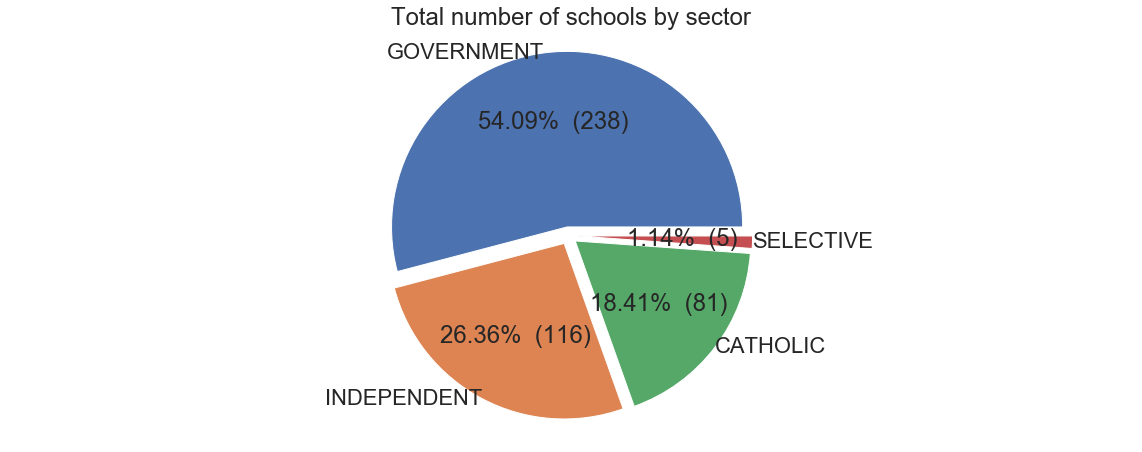

In [51]:
# Availability of School sectors
count = df1.loc[df1.Year == 2016].Sector.value_counts()
labels = count.index

sns.set_palette('hls', 4)
sns.set(font_scale=2)

plt.pie(count, labels=labels, autopct=make_autopct(count),\
        explode=[0.05, 0.05, 0.05, 0.05], labeldistance=1)

plt.title('Total number of schools by sector')
plt.axis('equal')

plt.show()

Majority of schools belong to the government. Surprisingly roughly 20% of schools are funded through the Catholic

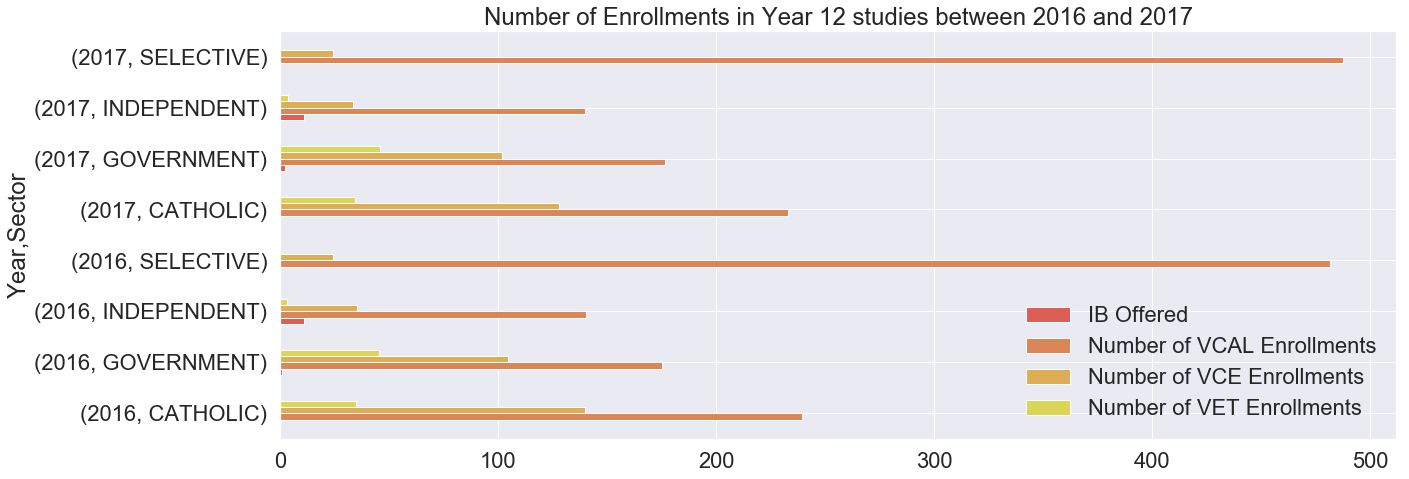

In [52]:
# Number of year 12 study enrollments
temp = df1.groupby(['Year', 'Sector'])[['Number of VCE Enrollments', 'Number of VET Enrollments',\
                         'Number of VCAL Enrollments']]

enrollments = df1.groupby(['Year', 'Sector'])[['IB Offered']].sum() + temp.mean()
enrollments['IB Offered'] = df1.groupby(['Year', 'Sector'])['IB Offered'].sum()
enrollments[enrollments.columns[1:]] = temp.mean()

sns.set_palette('hls', 20)

enrollments.plot.barh()

plt.title('Number of Enrollments in Year 12 studies between 2016 and 2017')

plt.show()

We can see that selective schools do not offer VCAL and mainly VCE (with a few VET options).  
Catholic and Government schools both share a similar ratio in the number of VCE, VET to VCAL enrollments.
Independent schools are similar to selective but also offer the choice of completing the IB instead of VCE (Only 1-2 schools in the government sector offer IB whilst 11 independent schools offer IB). Although we are focused on the VCE performances of a school, for this analysis we will ignore students undergoing IB who may have increased the schools performance if they did VCE.

#### A look into what differentiates a high performing school versus normal schools

In [53]:
# High performing schools if they are consistently achieving a median VCE study score over 35
hps = df1.loc[df1.loc[df1['Median VCE study score'] >= 35].School.duplicated().index].drop('Year', axis=1)
nps = df1.loc[df1.loc[df1['Median VCE study score'] < 35].School.duplicated().index].drop('Year', axis=1)

Differences will be calculated using:  
$\mu\text{(High Performing)} - \mu\text{(Normal)}$  
The overall difference will determine which attributes belong to the type of school  
For the IB Offered, we will use the sum instead of mean since it is a Boolean

In [54]:
# Differences
differences = pd.DataFrame(hps.mean() - nps.mean()).rename({0: 'Difference'}, axis=1)
differences.insert(1,'Better', pd.Series(np.where(differences['Difference'] > 0, True, False)).values)

In [55]:
# Use the sum for IB Offered since it is a boolean
differences.loc[differences.index == 'IB Offered'] = [hps.sum()['IB Offered'] - nps.sum()['IB Offered'], False]

In [56]:
differences.head(3)

,Difference,Better
Number of Unit 3/4 VCE Stubjects Offered,-1.838113,False
Number of VET Subjects Offered,-10.477601,False
IB Offered,-17.000000,False


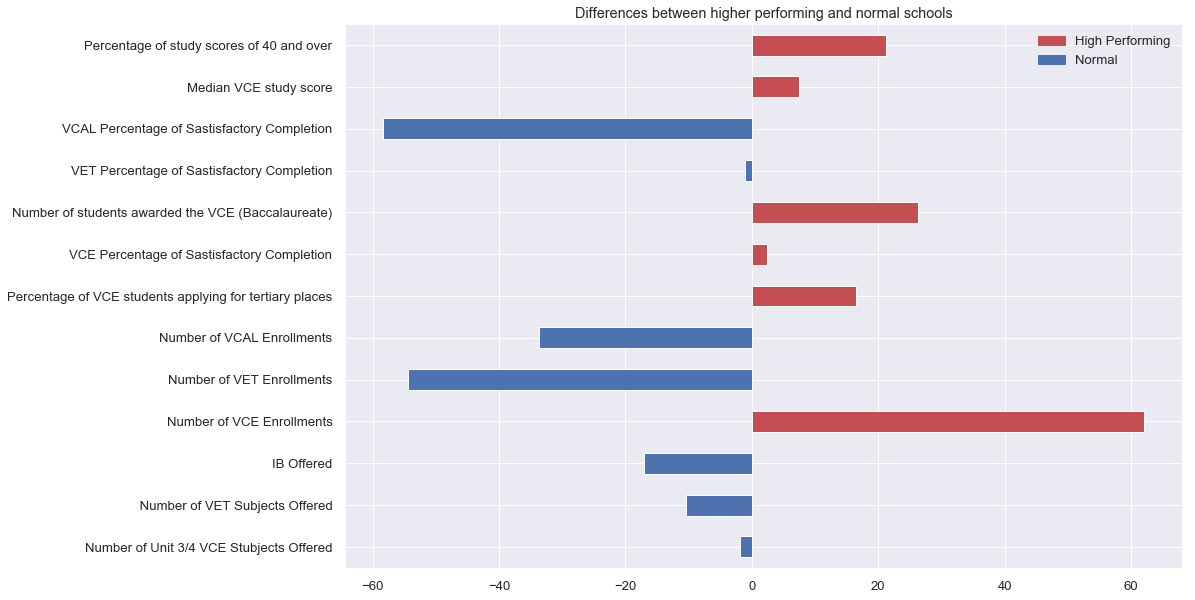

In [57]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.set(font_scale=1.2)
differences.Difference.plot(kind='barh', color=differences.Better.map({True: 'r', False: 'b'}))

red_patch = mpatches.Patch(color='r', label='High Performing')
blue_patch = mpatches.Patch(color='b', label='Normal')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Differences between higher performing and normal schools')

plt.show()

From what we can visually see, higher performing schools excel much more in:  
- Number of VCE enrollments
- Percentage that apply for terrtiary places
- Higher overall VCE completion and aawrds for the baccalaureate 
- Overall median VCE study score and the percentage of students that achieve study scores over 40
- It's plausible to think that schools offering IB will have a lower median study score. This is due to the higher achieving students choosing IB over VCE resulting in fewer students taking VCE

In [58]:
# Break into sectors
ind_ss = df1['Median VCE study score'].loc[df1['Sector'] == 'INDEPENDENT']
gov_ss = df1['Median VCE study score'].loc[df1['Sector'] == 'GOVERNMENT']
sel_ss = df1['Median VCE study score'].loc[df1['Sector'] == 'SELECTIVE']
cat_ss = df1['Median VCE study score'].loc[df1['Sector'] == 'CATHOLIC']

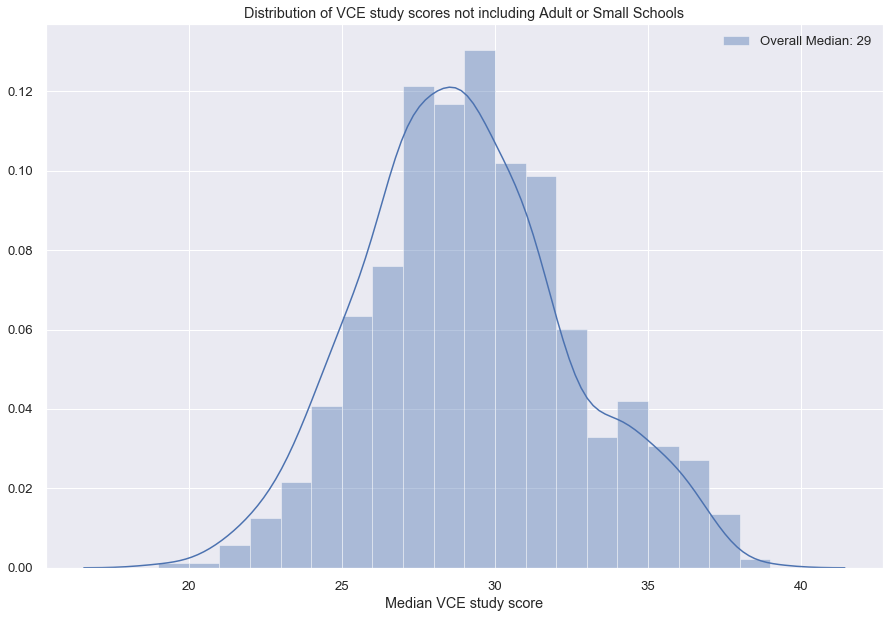

In [59]:
# Actual distribution of study scores ignoring adult schools and small schools
sns.distplot(df1['Median VCE study score'], bins=20, label='Overall Median: %d' % df1['Median VCE study score'].describe()['50%'])
plt.title("Distribution of VCE study scores not including Adult or Small Schools")
plt.legend()
plt.show()

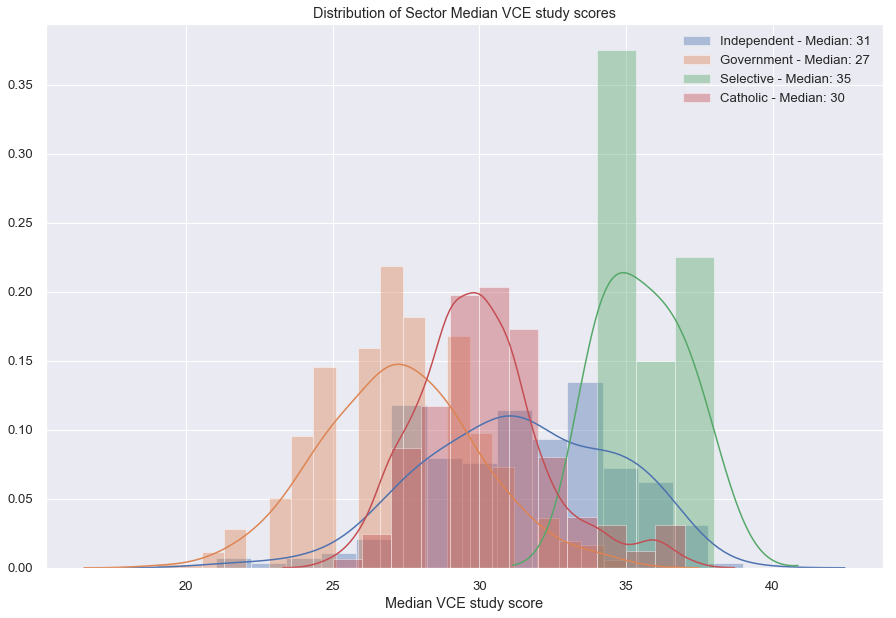

In [60]:
# Distribution of study scores
sns.distplot(ind_ss,bins=int(np.power(len(ind_ss),1/2)), label='Independent - Median: %d' % ind_ss.describe()['50%'])
sns.distplot(gov_ss,bins=int(np.power(len(gov_ss),1/2)), label='Government - Median: %d' % gov_ss.describe()['50%'])
sns.distplot(sel_ss,bins=int(np.power(len(sel_ss),1/2)), label='Selective - Median: %d' % sel_ss.describe()['50%'])
sns.distplot(cat_ss,bins=int(np.power(len(cat_ss),1/2)), label='Catholic - Median: %d' % cat_ss.describe()['50%'])

plt.title('Distribution of Sector Median VCE study scores')
plt.legend()
plt.show()

#### Does the location of school (Using the factor as Housing Rent Costs) matter

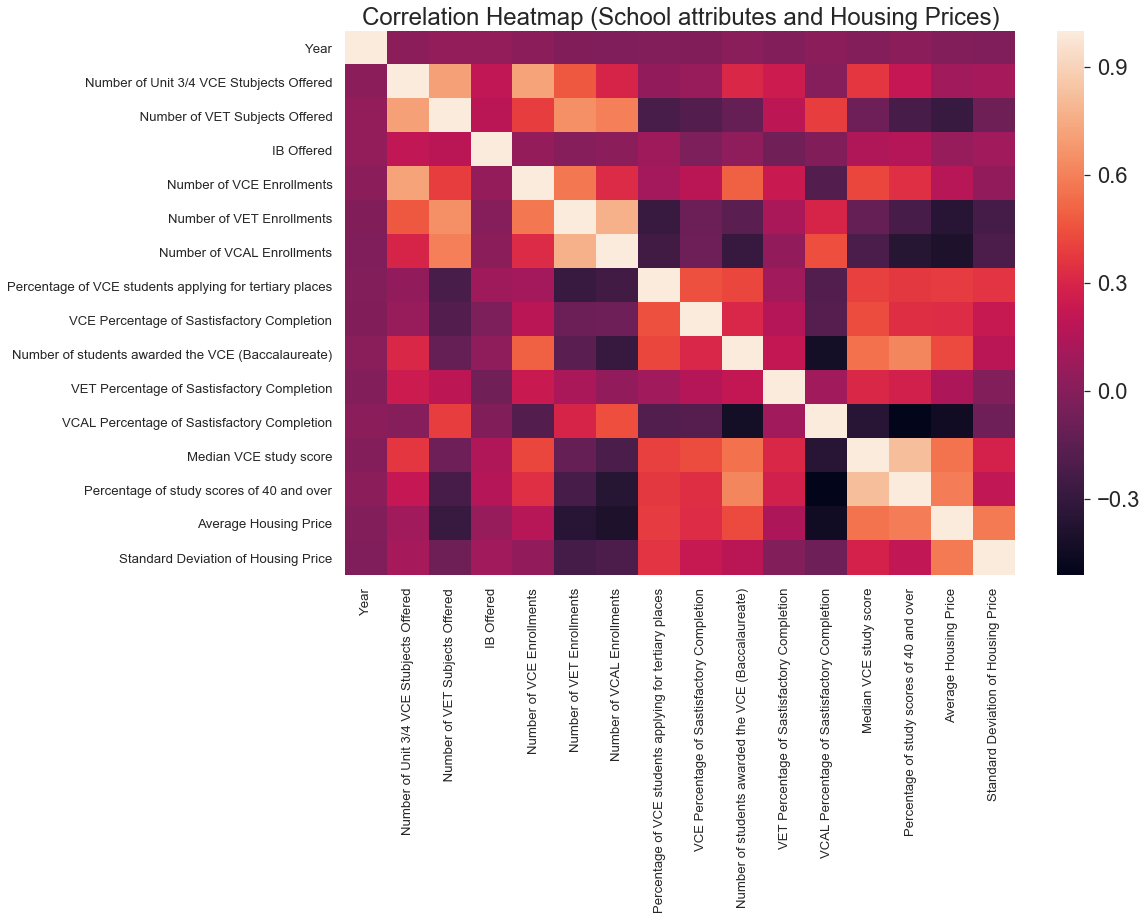

Correlation between Average Housing Price and Performance of School:
Median VCE study score: 0.5542
Percentage of study scores of 40 and over: 0.5899


In [61]:
# Correlation heatmap consisting of attributes from the VCAA dataset and Housing Prices
fig, axes = plt.subplots(figsize=(15,10))
sns.set(font_scale=2)

# This correlation only applies to government schools since students may come from different zones 
# if they are in selective or independent schools (inexclusive of schorlaship or accelerated program students)
correlation = df3.loc[df3.Sector == 'GOVERNMENT'].corr()

sns.heatmap(correlation)

plt.title('Correlation Heatmap (School attributes and Housing Prices)')

plt.show()

perf_corr = correlation['Average Housing Price'][['Median VCE study score', 'Percentage of study scores of 40 and over']]
print("Correlation between Average Housing Price and Performance of School:")
print("%s: %.4f\n%s: %.4f" % (perf_corr.index[0], perf_corr[0], perf_corr.index[1], perf_corr[1]))

The results above suggest a strong positive correlation with the housing rent of the suburb and the performance of the school.  
Although this correlation does not imply causality, it is still a plausible argument since households that can afford to pay higher rents will be able to afford a better lifestyle (ie afford educational resources and tutors), resulting in a better performance than those with a lower housing rent.
This argument however is invalid for selective schools which accept students from any locations, likewise independent schools, scholarship students and accelerated program students for government school who are allowed to attend schools outside their locality zones.

In [62]:
cost_corr = df3.loc[df3.Sector == 'GOVERNMENT'].sort_values(by='Average Housing Price', ascending=False)
print("Top 5 Highest rental suburbs:\nAverage Cost Per Week: $%d\nAverage Median Study Score: %d\n" %\
      (cost_corr.iloc[:5]['Average Housing Price'].mean(), cost_corr.iloc[:5]['Median VCE study score'].mean()))
print("Top 5 Lowest rental suburbs:\nAverage Cost Per Week: $%d\nAverage Median Study Score: %d" %\
      (cost_corr.iloc[-5:]['Average Housing Price'].mean(), cost_corr.iloc[-5:]['Median VCE study score'].mean()))

Top 5 Highest rental suburbs:
Average Cost Per Week: $576
Average Median Study Score: 32

Top 5 Lowest rental suburbs:
Average Cost Per Week: $232
Average Median Study Score: 25


In [63]:
school_count = df3.groupby('Locality')[['School']].count().rename({'School': 'Schools'}, axis=1)
ib_count = df3.groupby('Locality')[['IB Offered']].sum().rename({'IB Offered': 'Schools offering IB'}, axis=1)

availability = school_count + ib_count
availability['Schools'] = school_count
availability['Schools offering IB'] = ib_count

# Calculate the mean of the locality
attributes = df3[['Locality', 'Average Housing Price', 'Median VCE study score']].drop_duplicates().groupby('Locality').mean()

# Merge
availability = attributes.merge(availability, on='Locality', how='inner')

In [64]:
# Find out which suburbs offer the most variety in education
school_count = df3.groupby('Locality')[['School']].count().rename({'School': 'Schools'}, axis=1)
ib_count = df3.groupby('Locality')[['IB Offered']].sum().rename({'IB Offered': 'Schools offering IB'}, axis=1)

availability = school_count + ib_count
availability['Schools'] = school_count
availability['Schools offering IB'] = ib_count

# Calculate the mean of the locality
attributes = df3[['Locality', 'Average Housing Price', 'Median VCE study score']].drop_duplicates().groupby('Locality').mean()

# Merge
availability = attributes.merge(availability, on='Locality', how='inner')
availability = availability.sort_values(['Schools', 'Schools offering IB'], ascending=False).iloc[:10]

display(availability)

,Average Housing Price,Median VCE study score,Schools,Schools offering IB
Locality,,,,
KEW,481.000,33.000000,10,3
BERWICK,385.000,32.428571,10,0
SHEPPARTON,266.875,27.500000,10,0
WERRIBEE,333.125,30.500000,9,2
BALLARAT,270.625,30.666667,9,0
CRANBOURNE,370.000,28.000000,9,0
ESSENDON,377.500,29.500000,9,0
BROADMEADOWS,339.375,28.800000,8,0
CANTERBURY,462.875,33.500000,8,0


#### Where does the educational funding go

In [65]:
# Total costs of contractors by services provided
services = df5.groupby('Services provided').sum().sort_values(by=df5.columns[-1], ascending=False)

# Percentage of fund that is spent on contractors (df2 is by the millions)
pct = services.sum()[0]/(df2.loc[2016, 'Total liabilities']*10000)
print("A total of $%d was spent in 2016 on contractors, costing approximately %.2f%% of the total liabilities"\
     % (services.sum()[0], pct))

services = services.reset_index()
display(services.head(3))
display(df2)
print("The cost above is in the millions")

A total of $133586693 was spent in 2016 on contractors, costing approximately 5.98% of the total liabilities


,Services provided,Cost ($) ex GST
0,Contract Staff (Whole-of-Government State Purc...,48961504
1,"Professional Services (Research, Leadership an...",20609709
2,Professional Services,10538718


,Total financial assets,Total non-financial assets,Total assets,Total liabilities,Total equity
Year,,,,,
2016,3316,21999,25315,2234,23080
2017,3255,22494,25749,2498,23251


The cost above is in the millions


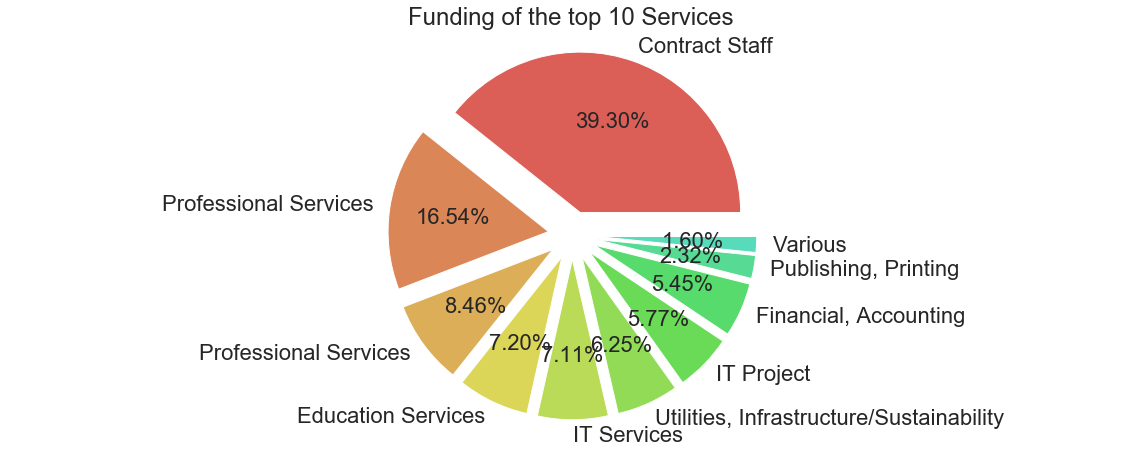

In [66]:
# Top 10 most funded services

# Reduce the length of the label and keep the important information
labels = services['Services provided'][:10].apply(lambda x: ' '.join(x.split()[:2])).str.strip(',')

sns.set_palette('hls', 20)

plt.rcParams['figure.figsize'] = (20.0, 7.5)
plt.rcParams.update({'font.size': 22})

plt.pie(services['Cost ($) ex GST '][:10], labels=labels, autopct='%.2f%%',\
        explode=[0.15 for i in labels])

plt.title('Funding of the top 10 Services')
plt.axis('equal')

plt.show()

#### Where do students go after graduating

In [67]:
# Drop missing values 
df4 = df4.loc[df4['DESTINATION '] != 'Unknown']

In [68]:
# Destinations of students by sector
destinations1 = df4.groupby('EDUCATION SECTOR')['DESTINATION '].value_counts()
# General destinations of students
destinations2 = df4.groupby('DESTINATION ')['STUDENT ID'].count()

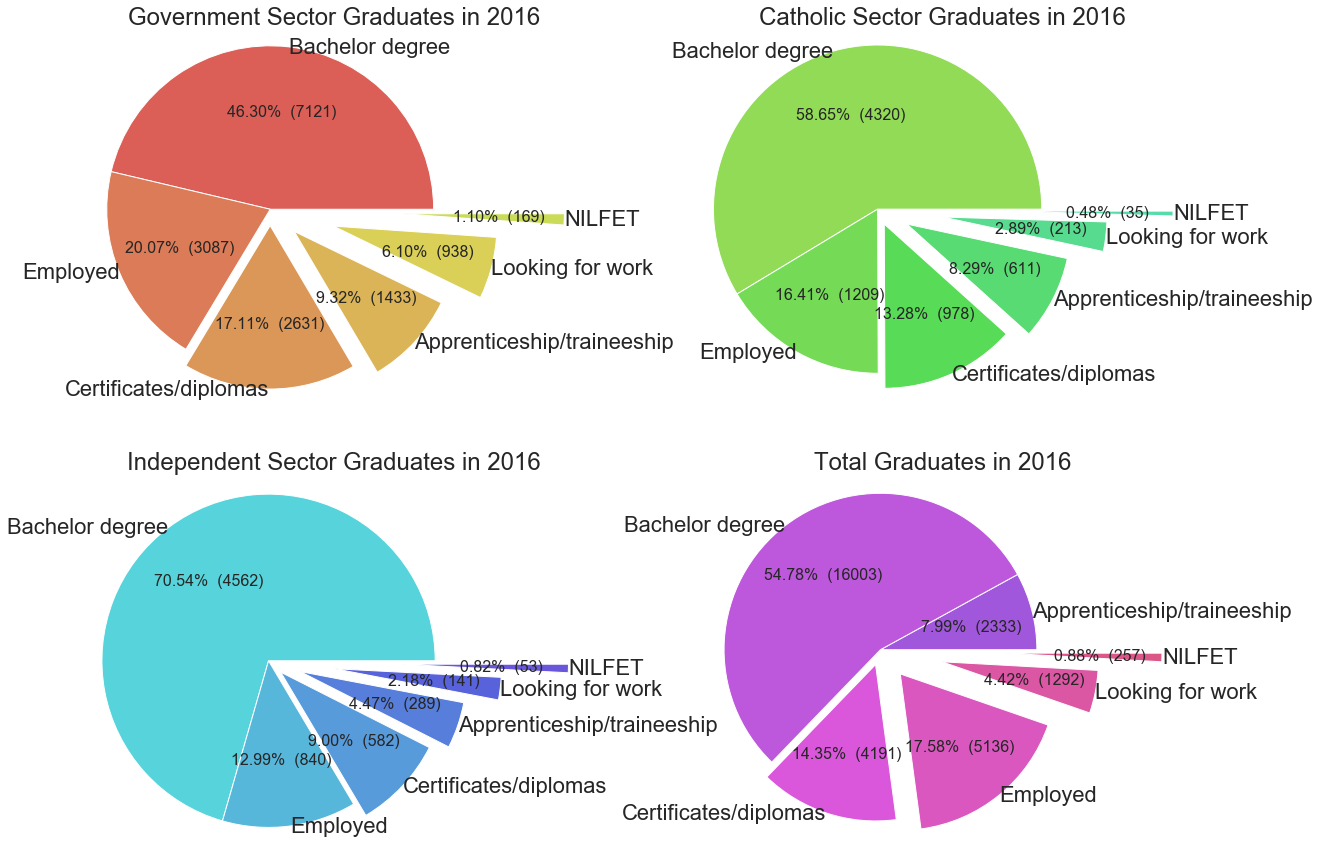

In [69]:
# 2016 Graduates
count = [destinations1.GOVERNMENT, destinations1.CATHOLIC, destinations1.INDEPENDENT, destinations2]
labels = [i.index for i in count]
colors = sns.color_palette('hls', 28)
explodes = [0, 0, .1, .2, .4, .8]

plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,15))

axes[0][0].pie(count[0], labels=labels[0], autopct=make_autopct(count[0]),\
        explode=explodes, labeldistance=1, colors=colors[:7])
axes[0][0].set(title='Government Sector Graduates in 2016')
axes[0][0].axis('equal')

axes[0][1].pie(count[1], labels=labels[1], autopct=make_autopct(count[1]),\
        explode=explodes, labeldistance=1, colors=colors[7:14])
axes[0][1].set(title='Catholic Sector Graduates in 2016')
axes[0][1].axis('equal')

axes[1][0].pie(count[2], labels=labels[2], autopct=make_autopct(count[2]),\
        explode=explodes, labeldistance=1, colors=colors[14:21])
axes[1][0].set(title='Independent Sector Graduates in 2016')
axes[1][0].axis('equal')

axes[1][1].pie(count[3], labels=labels[3], autopct=make_autopct(count[3]),\
        explode=explodes, labeldistance=1, colors=colors[21:28])
axes[1][1].set(title='Total Graduates in 2016')
axes[1][1].axis('equal')

plt.show()

**Unknown:** *Didn't Answer / Left Blank (Removed for visualizations)*  
**NILFET:** *Not in the labour force, employment or training*


In [70]:
grads = df1.groupby('Sector')['Percentage of VCE students applying for tertiary places'].mean()
print("Percentage of students that apply for tertiary places:")
print("Government: %.2f%%\nCatholic: %.2f%%\nIndependent: %.2f%%" % (grads[0], grads[1], grads[2]))
print("\nAlthough selective schools were included into the government sector for the survey, %.2f%% of \
selective school students applied for tertiary places" % grads[3])

Percentage of students that apply for tertiary places:
Government: 86.18%
Catholic: 74.63%
Independent: 87.88%

Although selective schools were included into the government sector for the survey, 97.60% of selective school students applied for tertiary places


Accross the board we can easily see that the majority of graduates persue tertiary education (Bachelors and Diplomas) and the rest entering the work force, with a small minority who become unemployed or NILFET. Of all the sectors, Independent schools yield the highest number of students who persue tertiary education whilst a small majority of graduates from government sectors go straight to the work force. 

# Labelling and Classifying High Performing Schools
**Schools with a median study score 35 and over are laballed as "high performing"**

We will break the data and train the KNN/DT model with schools in performances 2016, and test it with school performances in 2017.

1. Convert categorical data into numerical
2. Drop the school name and location (such that the DT will not be exposed to the name of the school)
3. Label the high performing school using the Median VCE study score
4. Feature scale X_train, X_test, y_train and y_test
5. Simulate values of k and calculate training, testing and missclassification values
6. Simulate various depths of DT and output the most optimal solution

In [71]:
# School ranking by performance 2016
ranking_16 = df1.loc[df1.Year == 2016].sort_values('Median VCE study score', ascending=False).reset_index(drop=True)

# School ranking by performance 2017
ranking_17 = df1.loc[df1.Year == 2017].sort_values('Median VCE study score', ascending=False).reset_index(drop=True)

In [72]:
# Keep this for visualizations
high_performing_schools_16 = ranking_16.loc[ranking_16['Median VCE study score'] >= 35]
high_performing_schools_17 = ranking_17.loc[ranking_17['Median VCE study score'] >= 35]

In [73]:
# Convert categorical to numerical
ranking_16.insert(2, 'Selective', pd.Series(np.where(ranking_16['Sector'] == 'SELECTIVE', 1, 0)).values)
ranking_16.insert(3, 'Government', pd.Series(np.where(ranking_16['Sector'] == 'GOVERNMENT', 1, 0)).values)
ranking_16.insert(4, 'Independent', pd.Series(np.where(ranking_16['Sector'] == 'INDEPENDENT', 1, 0)).values)
ranking_16.insert(5, 'Catholic', pd.Series(np.where(ranking_16['Sector'] == 'CATHOLIC', 1, 0)).values)

# Drop unneeded columns
ranking_16.drop(columns=['Year', 'Sector', 'School', 'Locality'], inplace=True)

# Label high performing schools
ranking_16.insert(17, 'label', pd.Series(np.where(ranking_16['Median VCE study score'] >= 35, 1, 0)).values)
ranking_16.drop(columns=['Median VCE study score'], inplace=True)

# Percentage of high performing schools in 2016
print("%.2f%% of schools have a median VCE study score greater than equal to 35 in 2016" \
      % (sum(ranking_16.label)/len(df1) * 100))

3.51% of schools have a median VCE study score greater than equal to 35 in 2016


In [74]:
# Convert categorical to numerical
ranking_17.insert(2, 'Selective', pd.Series(np.where(ranking_17['Sector'] == 'SELECTIVE', 1, 0)).values)
ranking_17.insert(3, 'Government', pd.Series(np.where(ranking_17['Sector'] == 'GOVERNMENT', 1, 0)).values)
ranking_17.insert(4, 'Independent', pd.Series(np.where(ranking_17['Sector'] == 'INDEPENDENT', 1, 0)).values)
ranking_17.insert(5, 'Catholic', pd.Series(np.where(ranking_17['Sector'] == 'CATHOLIC', 1, 0)).values)

# Drop unneeded columns
ranking_17.drop(columns=['Year', 'Sector', 'School', 'Locality'], inplace=True)

# Label high performing schools
ranking_17.insert(17, 'label', pd.Series(np.where(ranking_17['Median VCE study score'] >= 35, 1, 0)).values)
ranking_17.drop(columns=['Median VCE study score'], inplace=True)

# Percentage of high performing schools in 2017
print("%.2f%% of schools have a median VCE study score greater than equal to 35 in 2017" \
      % (sum(ranking_17.label)/len(df1) * 100))

3.85% of schools have a median VCE study score greater than equal to 35 in 2017


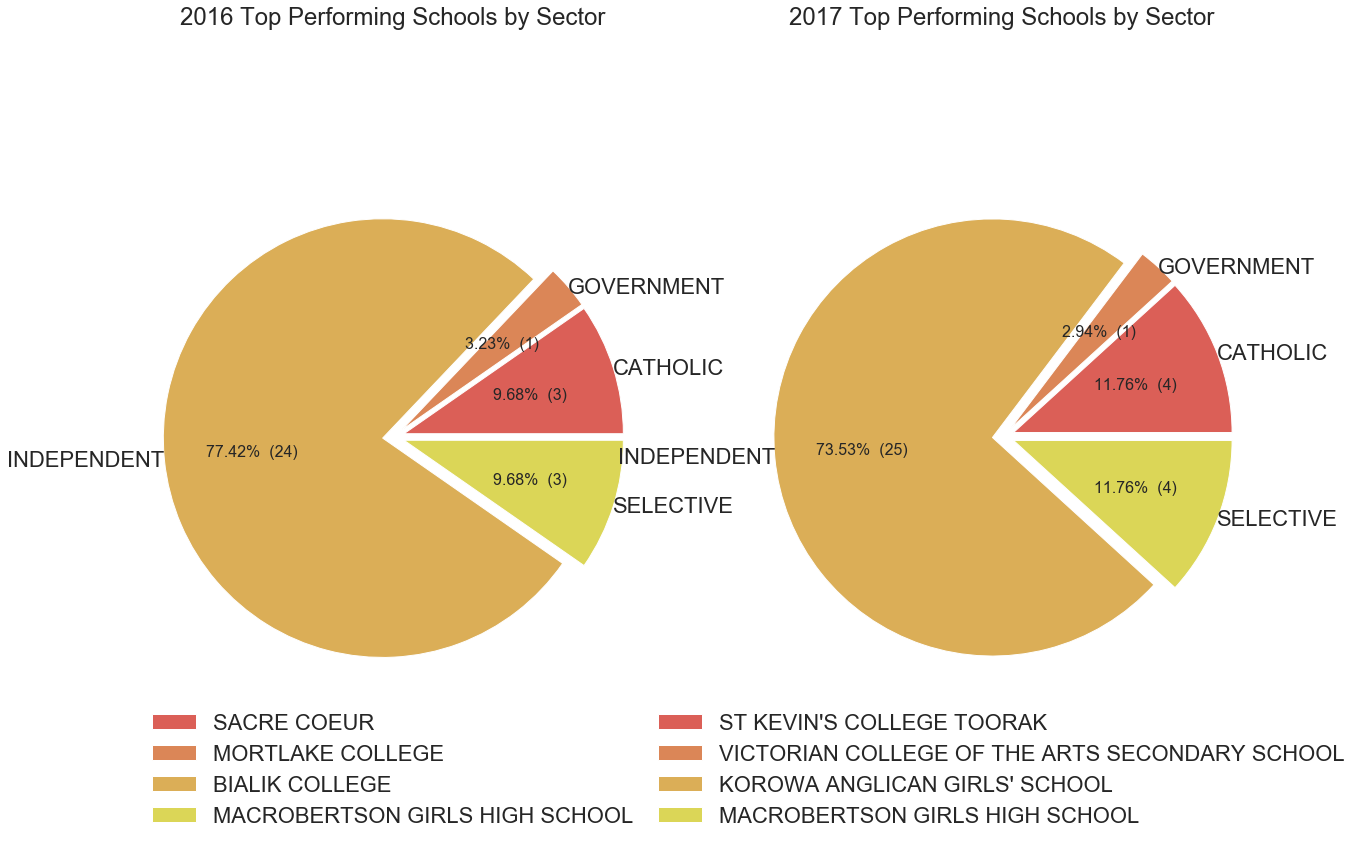

In [75]:
# School Performances 
hps16 = high_performing_schools_16.groupby('Sector')['School'].count()
hps16_labels = hps16.index

hps17 = high_performing_schools_17.groupby('Sector')['School'].count()
hps17_labels = hps17.index

sns.set_palette('hls', 20)

fig, axes = plt.subplots(ncols=2, figsize=(20,15))
axes[0].pie(hps16, labels=hps16_labels, autopct=make_autopct(hps16),\
        explode=[0.05, 0.05, 0.05, 0.05], labeldistance=1)
axes[0].set(title='2016 Top Performing Schools by Sector')
axes[0].axis('equal')
axes[0].legend(high_performing_schools_16.groupby('Sector')['School'].first(), loc='lower center')

axes[1].pie(hps17, labels=hps17_labels, autopct=make_autopct(hps17),\
        explode=[0.05, 0.05, 0.05, 0.05], labeldistance=1)
axes[1].set(title='2017 Top Performing Schools by Sector')
axes[1].axis('equal')
axes[1].legend(high_performing_schools_17.groupby('Sector')['School'].first(), loc='lower center')


plt.show()

In [76]:
temp = defaultdict(int)
optimal = pd.DataFrame(columns=df1.columns)

for i in df1.columns[4:]:
    for j in df1.sort_values(by=i, ascending=False)[:10].School:
        temp[j] += 1
temp = sorted(temp.items(), key = lambda v: v[1], reverse=True)[:5]
for i in temp:
    optimal = optimal.append(df1.loc[df1.School == i[0]])
optimal = optimal.drop_duplicates(subset='School').drop('Year',axis=1)
optimal.set_index('School', inplace=True)
display(optimal)

,Sector,Locality,Number of Unit 3/4 VCE Stubjects Offered,Number of VET Subjects Offered,IB Offered,Number of VCE Enrollments,Number of VET Enrollments,Number of VCAL Enrollments,Percentage of VCE students applying for tertiary places,VCE Percentage of Sastisfactory Completion,Number of students awarded the VCE (Baccalaureate),VET Percentage of Sastisfactory Completion,VCAL Percentage of Sastisfactory Completion,Median VCE study score,Percentage of study scores of 40 and over
School,,,,,,,,,,,,,,,
BENDIGO SENIOR SECONDARY COLLEGE,GOVERNMENT,BENDIGO,82,42,0,1175,601,267,59,95,6,84.0,76.0,27.0,1.8
MACROBERTSON GIRLS HIGH SCHOOL,SELECTIVE,MELBOURNE,49,12,0,515,30,0,98,100,136,86.0,0.0,37.0,36.6
MELBOURNE HIGH SCHOOL,SELECTIVE,SOUTH YARRA,59,17,0,686,71,0,94,100,121,99.0,0.0,36.0,30.6
BIALIK COLLEGE,INDEPENDENT,HAWTHORN EAST,40,12,0,156,72,0,100,100,4,97.0,0.0,37.0,35.5
WERRIBEE SECONDARY COLLEGE,GOVERNMENT,WERRIBEE,78,40,1,313,142,81,81,94,14,65.0,92.0,30.0,10.1


From 2016 to 2017, 3 more schools have obtained a median study score of 35 or above.

In [77]:
# Calculate the NMI of high performing schools
NMI_16 = pd.DataFrame([mutual_info(ranking_16[i],ranking_16.label) for i in ranking_16.columns[:-1]],\
                      index=ranking_16.columns[:-1], columns=['NMI'])
NMI_17 = pd.DataFrame([mutual_info(ranking_17[i],ranking_17.label) for i in ranking_17.columns[:-1]],\
                      index=ranking_17.columns[:-1], columns=['NMI'])

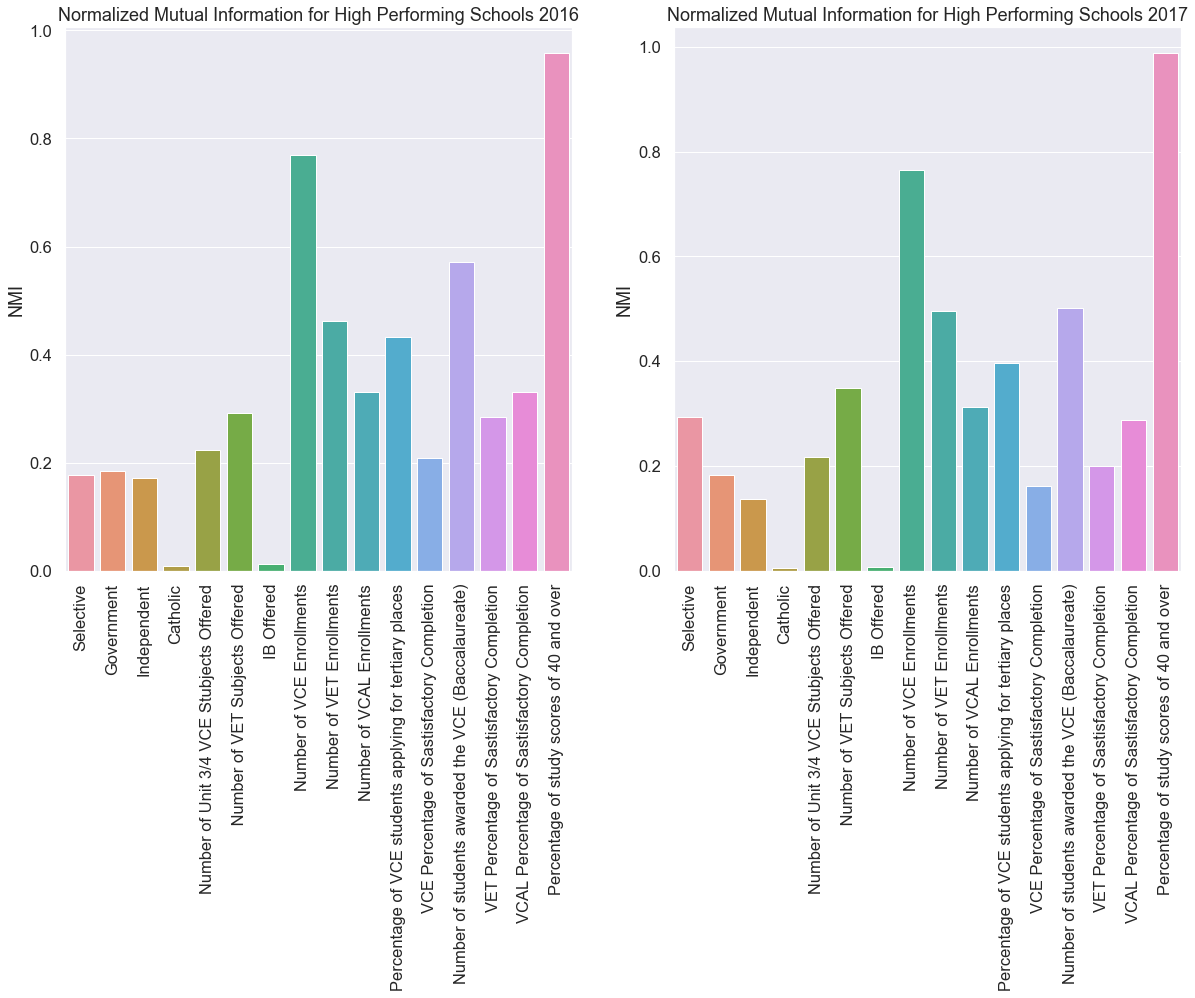

In [78]:
# Visualization of the NMI
sns.set_palette('hls', 20)
sns.set(font_scale=1.5)

fig, axes = plt.subplots(ncols=2, figsize=(20,10))

sns.barplot(NMI_16.index, NMI_16.NMI, ax=axes[0])
axes[0].tick_params('x', labelrotation=90)
axes[0].set(title='Normalized Mutual Information for High Performing Schools 2016')
sns.barplot(NMI_17.index, NMI_17.NMI, ax=axes[1])
axes[1].tick_params('x', labelrotation=90)
axes[1].set(title='Normalized Mutual Information for High Performing Schools 2017')

plt.show()

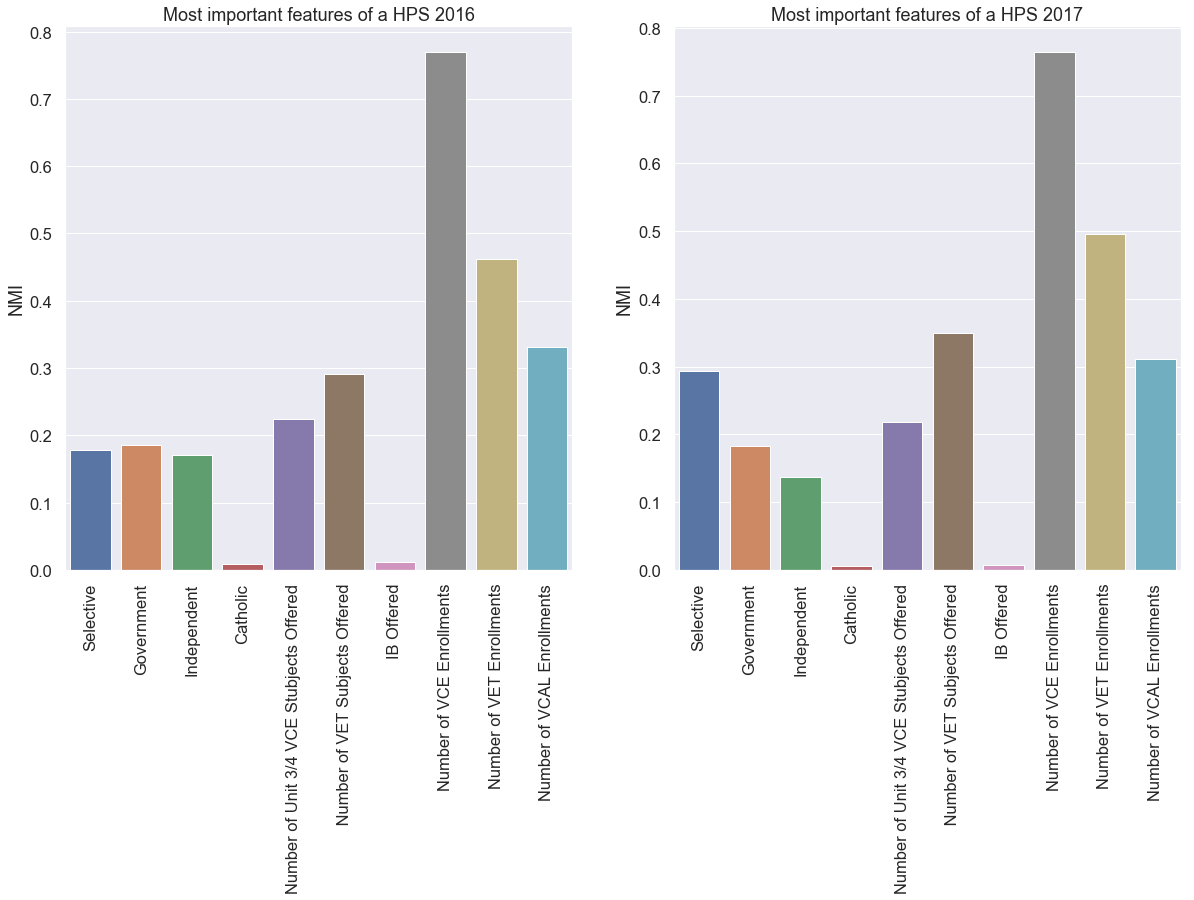

In [79]:
sns.set_palette('hls', 20)
sns.set(font_scale=1.5)

fig, axes = plt.subplots(ncols=2, figsize=(20,10))

sns.barplot(NMI_16.index[:10], NMI_16.NMI.iloc[:10], ax=axes[0])
axes[0].tick_params('x', labelrotation=90)
axes[0].set(title='Most important features of a HPS 2016')
sns.barplot(NMI_17.index[:10], NMI_17.NMI.iloc[:10], ax=axes[1])
axes[1].tick_params('x', labelrotation=90)
axes[1].set(title='Most important features of a HPS 2017')

plt.show()

In [80]:
# Train data is 2016
X_train = ranking_16[ranking_16.columns[:-1]]
y_train = ranking_16[ranking_16.columns[-1]]

# Test data is 2017
X_test = ranking_17[ranking_17.columns[:-1]]
y_test = ranking_17[ranking_17.columns[-1]]

# Feature Scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Min, Max, Mean and SD for the train/test data
print("X_train:  (%.2f,%.2f,%.2f,%.2f)" % (X_train[:,].min(),X_train[:,].max(),X_train[:,].mean(),X_train[:,].std()))
print("X_test:   (%.2f,%.2f,%.2f,%.2f)" % (X_test[:,].min(),X_test[:,].max(),X_test[:,].mean(),X_test[:,].std()))

X_train:  (-13.36,9.33,0.00,1.00)
X_test:   (-5.09,9.33,-0.01,0.97)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [81]:
# Number of k values to be tested
runs = 32
k_range = [i for i in range(1,runs)]
results = pd.DataFrame(index=k_range,columns=['Train','Test','Cross Validation'])

# Calculate the accuracy of each k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Prediction
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    
    # Calculate 10 fold cross validation
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    
    # Apeend to dataframe
    results.loc[k] = [accuracy_score(y_train, train_pred)*100,\
                      accuracy_score(y_test, test_pred)*100,\
                      scores.mean()]

# Calculate the misclassification error given by [MSE = 1 - CV]
results.insert(3, 'Missclassification Error', [1 - x for x in results['Cross Validation']])

# Find the best K for the model
optimal_k = results.loc[results['Missclassification Error'] == results['Missclassification Error'].min()]
print("The optimal number of neighbors is", optimal_k.index.values,\
      "with a missclassification error of", optimal_k['Missclassification Error'].values)

The optimal number of neighbors is [3] with a missclassification error of [0.03596195]


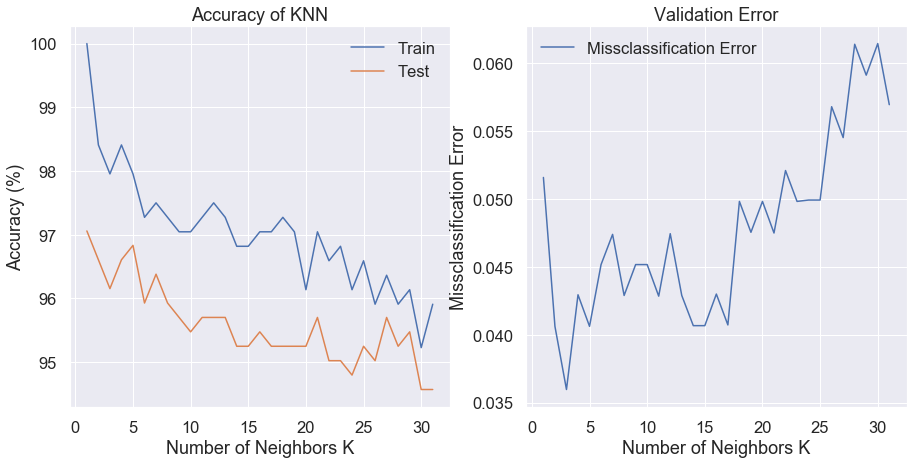

With the optimal number of neighbours given as [3] :
Train Accuracy: 97.95% 
Test Accuracy: 96.15%


In [82]:
# Visualization of the results
sns.set(font_scale=1.5)

fig, axes = plt.subplots(ncols=2, figsize=(15,7))

axes[0].plot(results[results.columns[:2]])
axes[0].set(title="Accuracy of KNN", xlabel="Number of Neighbors K", ylabel="Accuracy (%)")

axes[0].legend(results.columns[:2])

axes[1].plot(results['Missclassification Error'])
axes[1].set(title="Validation Error", xlabel="Number of Neighbors K", ylabel="Missclassification Error")
axes[1].legend()

plt.show()

# Justification
print("With the optimal number of neighbours given as" , optimal_k.index.values,\
     ":\nTrain Accuracy: %.2f%%" % optimal_k.Train, "\nTest Accuracy: %.2f%%" % optimal_k.Test)

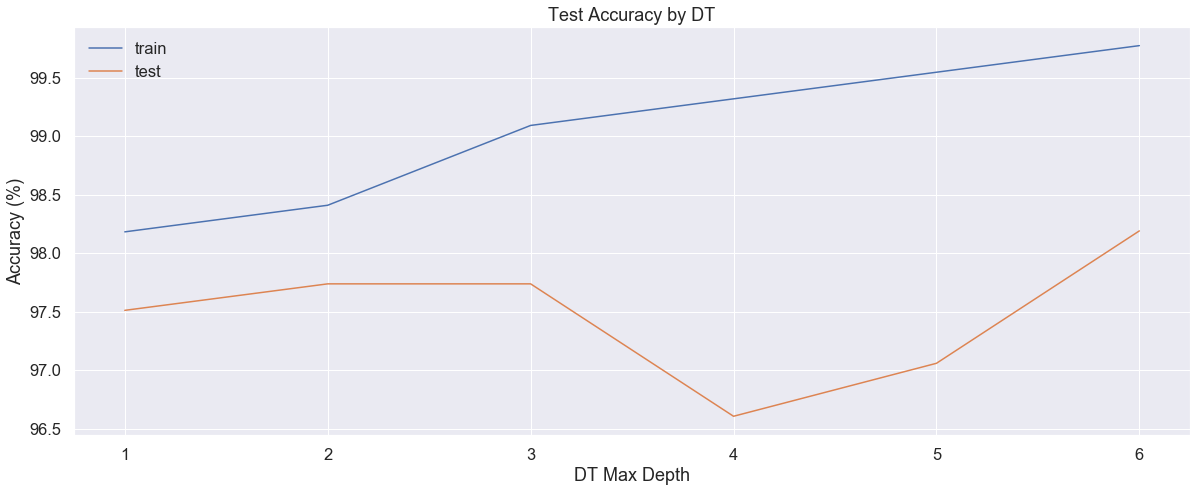

Highest test accuracy recorded is 98.19% with train accuracy 99.77% with max_depth equal to [6]


In [83]:
# Number of max_depth values to be tested
runs = 32
n = [i for i in range(1,runs)]
results = pd.DataFrame(index=n,columns=['train', 'test'])
for i in n:
    # DT with criterion information gain (entropy)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    # If the accuracy is 100% we are overfitting so stop
    if (accuracy_score(y_train, train_pred)*100) == 100:
        break
    results.loc[i] = [accuracy_score(y_train, train_pred)*100, accuracy_score(y_test, test_pred)*100]
    
# Plot
plt.plot(results)

plt.title("Test Accuracy by DT")
plt.xlabel("DT Max Depth")
plt.ylabel("Accuracy (%)")

plt.legend(results.columns)

plt.show()

optimal_max_depth = results.loc[results.test == results.test.max()].index.values

print("Highest test accuracy recorded is %.2f%% with train accuracy %.2f%% with max_depth equal to" % (results.test.max(), results.train.max()), optimal_max_depth)

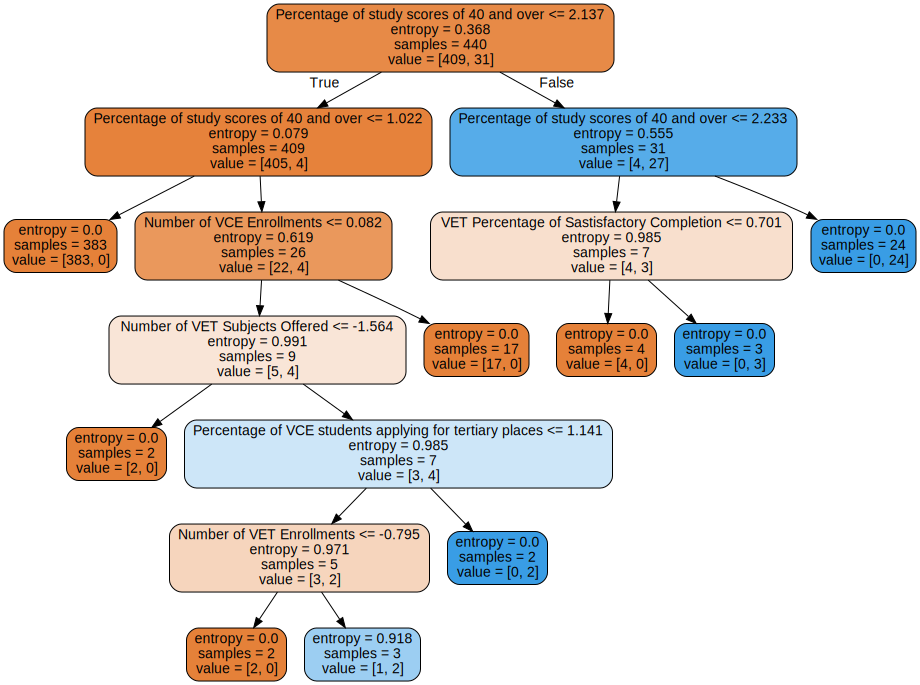

In [84]:
# Visualize the DT and entropy
export_graphviz(DecisionTreeClassifier(criterion='entropy', max_depth = optimal_max_depth[0]).fit(X_train, y_train),\
                out_file="mytree.dot",feature_names = ranking_16.columns[:-1],filled=True,rounded=True)

with open("./mytree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

# Predicting the sector of the school
By labelling the sector of the school as [selective, government, indepdenent, catholic] as [1, 2, 3, 4] respectively, we will attempt to fit a model that will predict the sector of school

In [85]:
# Make a copy of the dataframe
sectors = df1.copy()

In [86]:
# Label the sectors 
labels = {'SELECTIVE': 1, 'GOVERNMENT': 2, 'INDEPENDENT': 3, 'CATHOLIC': 4}
sectors['Sector'] = sectors['Sector'].map(labels)

# Drop unneeded columns
sectors.drop(columns=['Year', 'School', 'Locality'], inplace=True)

In [87]:
# Split data into train and test (70% to 30%)
X_train, X_test, y_train, y_test = train_test_split(sectors[sectors.columns[1:]], \
                                                    sectors[sectors.columns[0]], test_size=0.3, random_state = 42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


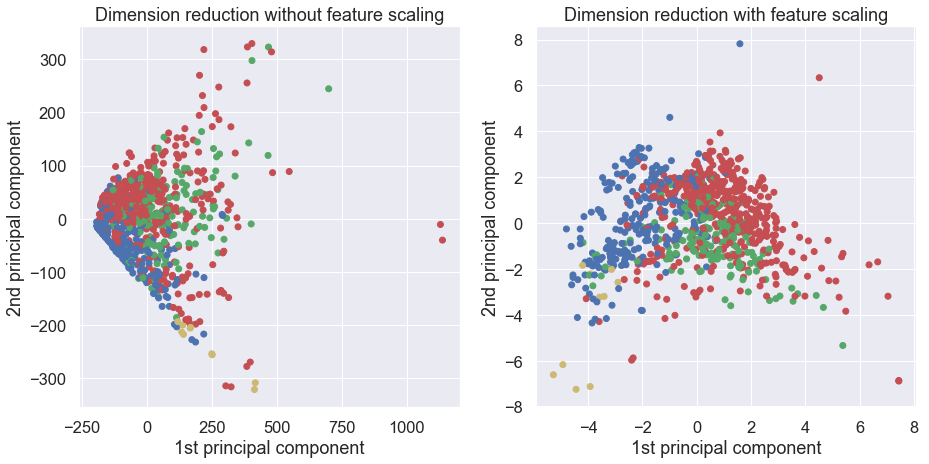

In [88]:
# Dimension reduction on the dataset
X = sectors[sectors.columns[1:]]
y = sectors[sectors.columns[0]]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Reduce to 2 dimensions
X_reduced = PCA(n_components=2).fit_transform(X)
X_reduced_scaled = PCA(n_components=2).fit_transform(X_scaled)

colors = df1.Sector.replace(['GOVERNMENT', 'INDEPENDENT', 'CATHOLIC', 'SELECTIVE'],['r','b', 'g', 'y'])

# PCA visualization
sns.set(font_scale=1.5)

fig, axes = plt.subplots(ncols=2, figsize=(15,7))

axes[0].scatter(X_reduced[:,0],X_reduced[:,1], color=colors)
axes[0].set(xlabel='1st principal component',ylabel='2nd principal component', \
            title='Dimension reduction without feature scaling')

axes[1].scatter(X_reduced_scaled[:,0],X_reduced_scaled[:,1], color=colors)
axes[1].set(xlabel='1st principal component',ylabel='2nd principal component', \
            title='Dimension reduction with feature scaling')

plt.show()

The PCA for ncomponents=2 doesn't yield that much of a change as expected. Although numerous features have been reduced, there is still a significant spread in the feature scaling (but reduced by a factor of at least 10 compared to the original).
However, dimensionality reduction will lose information, in general. PCA-based dimensionality reduction tends to minimize that information loss, dropping dimensions with the lower proprtional variances computed from the covariance matrix

In [89]:
# Feature Scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Min, Max, Mean and SD for the train/test data
print("X_train:  (%.2f,%.2f,%.2f,%.2f)" % (X_train[:,].min(),X_train[:,].max(),X_train[:,].mean(),X_train[:,].std()))
print("X_test:   (%.2f,%.2f,%.2f,%.2f)" % (X_test[:,].min(),X_test[:,].max(),X_test[:,].mean(),X_test[:,].std()))

X_train:  (-15.07,8.43,-0.00,1.00)
X_test:   (-5.16,9.06,0.03,0.99)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


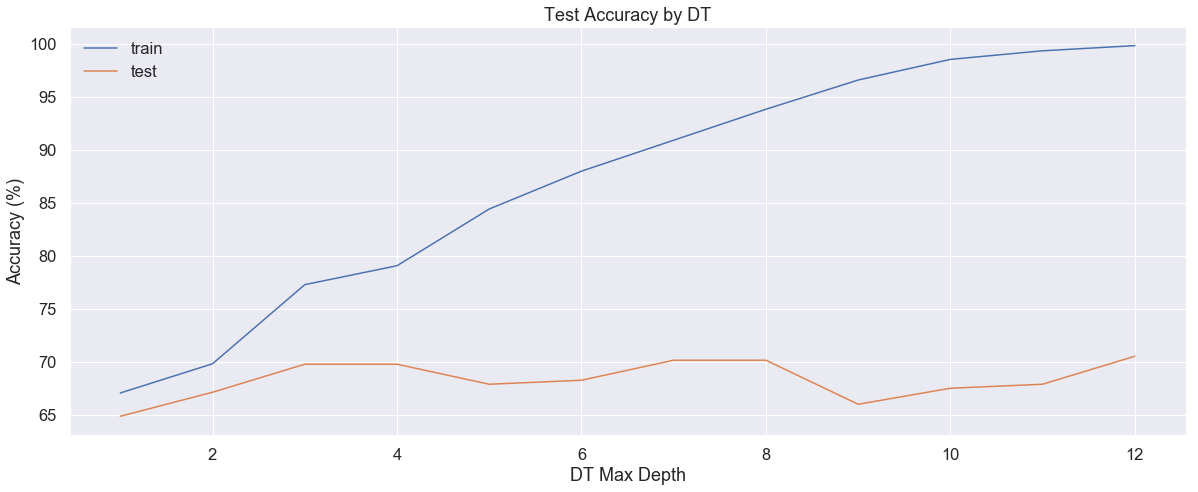

Highest test accuracy recorded is 70.57% with train accuracy 99.84% with max_depth equal to [12]


In [90]:
# Number of max_depth values to be tested
runs = 32
n = [i for i in range(1,runs)]
results = pd.DataFrame(index=n,columns=['train', 'test'])
for i in n:
    # DT with criterion information gain (entropy)
    dt = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    # If the accuracy is 100% we are overfitting so stop
    if (accuracy_score(y_train, train_pred)*100) == 100:
        break
    results.loc[i] = [accuracy_score(y_train, train_pred)*100, accuracy_score(y_test, test_pred)*100]
    
# Plot
plt.plot(results)

plt.title("Test Accuracy by DT")
plt.xlabel("DT Max Depth")
plt.ylabel("Accuracy (%)")

plt.legend(results.columns)

plt.show()

optimal_max_depth = results.loc[results.test == results.test.max()].index.values

print("Highest test accuracy recorded is %.2f%% with train accuracy %.2f%% with max_depth equal to" % (results.test.max(), results.train.max()), optimal_max_depth)

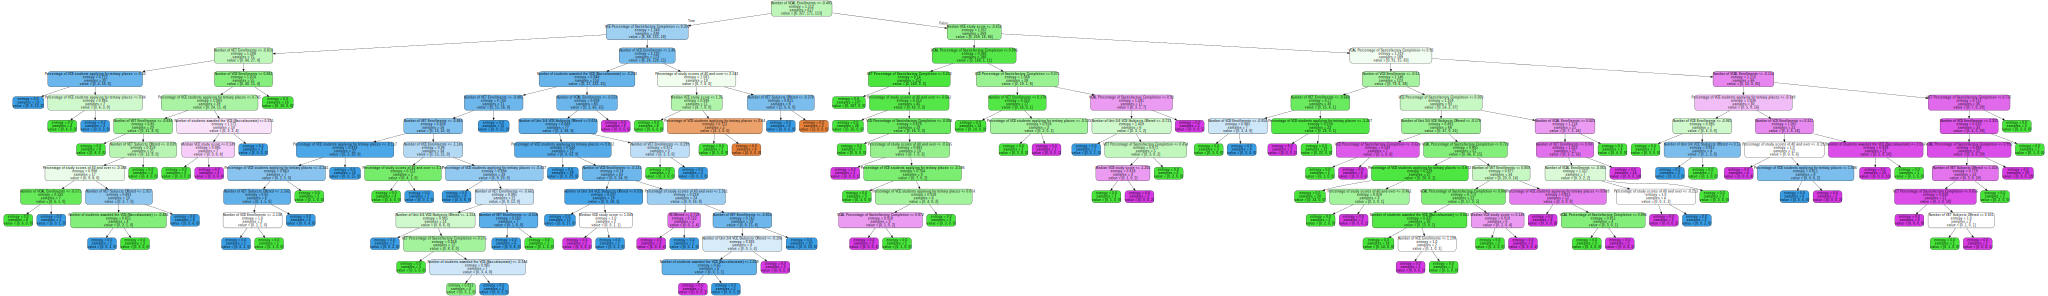

In [91]:
# Visualize the DT and entropy
export_graphviz(DecisionTreeClassifier(criterion='entropy', max_depth = optimal_max_depth[0]).fit(X_train, y_train),\
                out_file="mytree.dot",feature_names = sectors.columns[1:],filled=True,rounded=True)

with open("./mytree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)